In [ ]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 512.4/512.4 KB 17.3 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import numpy as np
import torchvision
from torchvision import transforms
from torchmetrics.classification import BinaryF1Score, BinaryAccuracy, BinaryPrecision
from torch.optim.lr_scheduler import StepLR

In [ ]:
!pip install datasets
from datasets import load_dataset
DS = load_dataset("scene_parse_150")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 452.9/452.9 KB 35.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 28.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 20.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 28.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 21.3 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/20210 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3352 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Dataset scene_parse_150 downloaded and prepared to /root/.cache/huggingface/datasets/scene_parse_150/scene_parsing/1.0.0/d998c54e1b5c5bad12b4d2ec7e1a5f74eee4c153bc1b089a0001677ae9b3fd75. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
!pip install transformers
from transformers import BeitConfig, BeitModel

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 90.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 101.3 MB/s eta 0:00:00


In [ ]:
from transformers.models.beit.modeling_beit import BeitForImageClassification
from transformers import BeitForSemanticSegmentation
import json
from huggingface_hub import cached_download, hf_hub_url

repo_id = "huggingface/label-files"
filename = "ade20k-id2label.json"
id2label = json.load(open(cached_download(hf_hub_url(repo_id, filename, repo_type="dataset")), "r"))
id2label = {int(k): v for k, v in id2label.items()}
label2id = {v: k for k, v in id2label.items()}
num_labels = len(id2label)

model = BeitForSemanticSegmentation.from_pretrained("microsoft/beit-base-finetuned-ade-640-640")

/usr/local/lib/python3.8/dist-packages/huggingface_hub/file_download.py:594: FutureWarning: `cached_download` is the legacy way to download files from the HF hub, please consider upgrading to `hf_hub_download`
  warnings.warn(


Downloading:   0%|          | 0.00/2.81k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/6.97k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/900M [00:00<?, ?B/s]

In [ ]:
model.parameters

<bound method Module.parameters of BeitForSemanticSegmentation(
  (beit): BeitModel(
    (embeddings): BeitEmbeddings(
      (patch_embeddings): BeitPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): BeitEncoder(
      (layer): ModuleList(
        (0): BeitLayer(
          (attention): BeitAttention(
            (attention): BeitSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=False)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
              (relative_position_bias): BeitRelativePositionBias()
            )
            (output): BeitSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
    

In [ ]:
sum(p.numel() for p in model.parameters())

163407980

In [ ]:
DS

DatasetDict({
    train: Dataset({
        features: ['image', 'annotation', 'scene_category'],
        num_rows: 20210
    })
    test: Dataset({
        features: ['image', 'annotation', 'scene_category'],
        num_rows: 3352
    })
    validation: Dataset({
        features: ['image', 'annotation', 'scene_category'],
        num_rows: 2000
    })
})

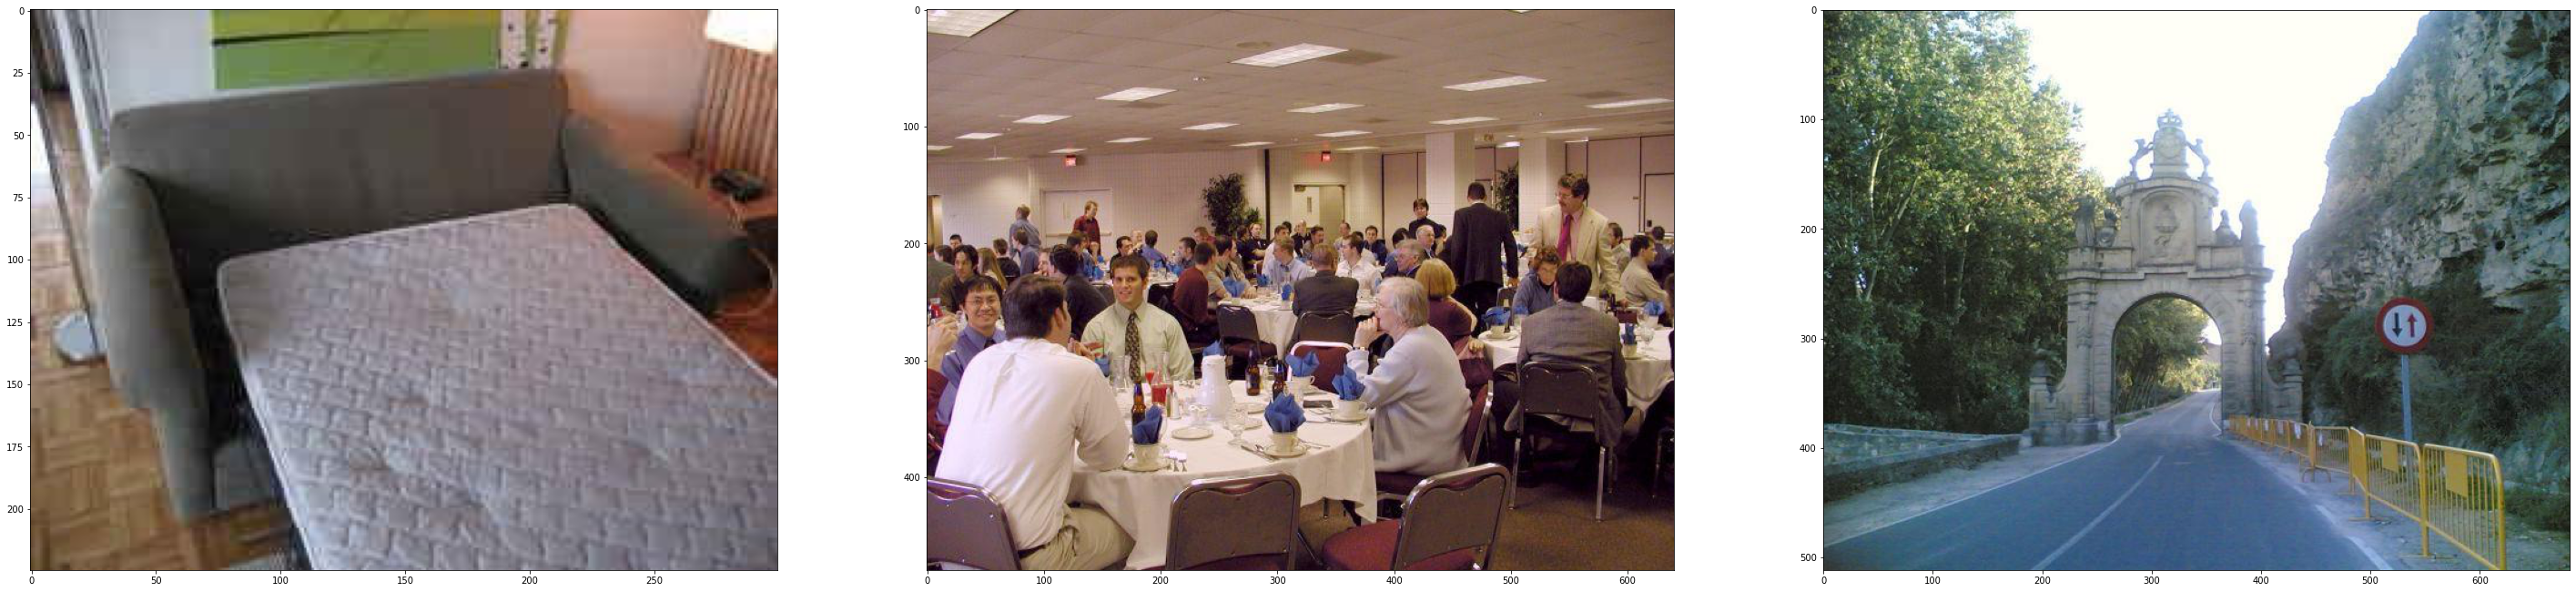

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=[20,20])
plt.subplot(1,3,1)
plt.imshow(DS["train"][963]["image"])
plt.subplot(1,3,2)
plt.imshow(DS["train"][567]["image"])
plt.subplot(1,3,3)
plt.imshow(DS["train"][987]["image"])

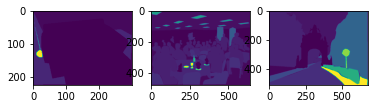

In [ ]:
plt.subplot(1,3,1)
plt.imshow(DS["train"][963]["annotation"])
plt.subplot(1,3,2)
plt.imshow(DS["train"][567]["annotation"])
plt.subplot(1,3,3)
plt.imshow(DS["train"][987]["annotation"])